In [1]:
import math
import numpy as np
import pandas as pd

# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [9]:
train = pd.read_csv("./data/train_all_features.csv")
# 查看样本总量
train.shape
# 查看good样本和bad样本数量,方便计算WOE
train["isFraud"].value_counts().values

(144233, 434)

array([132915,  11318])

In [10]:
# 获取缺失值超过95%的特征列并去除
percent_95NA_cols = [
    col for col in train.columns
    if sum(train[col].isnull()) / 144233 >=0.95
]
train = train.drop(percent_95NA_cols, axis=1)

### WOE编码

In [11]:
def get_col_woe_score(col_name:str, train_df:pd.DataFrame):
    """
    根据特征列获取分箱后的woe值
    好样本数量:132915
    坏样本数量:11318
    Args:
        col_name (str): 获取woe值的特征列名
        train_df (DataFrame): 训练数据集

    return:
        bin_woe_map_value (dict): {bin_name : woe_score}
        train_df (DataFrame): 处理好的dataframe
    """
    col_name_df = train_df[[col_name,"isFraud"]]
    bin_woe_map_value = {}
    for value in train[col_name].unique():
        good_bin_cnt, bad_bi_cnt = col_name_df[col_name_df[col_name]==value]["isFraud"].value_counts().values
        woe = np.log(bad_bi_cnt / 11318) - np.log(good_bin_cnt / 132915)
        bin_woe_map_value[value] = woe
    
    train_df[col_name+"_woe"] = train_df[col_name].map(bin_woe_map_value)
    train_df.drop(col_name,axis=1,inplace=True)

    return train_df,bin_woe_map_value

- 自定义分箱

(array([  1448.,    311.,    307.,    199.,    739.,   2861.,   3027.,
          5345.,  16983., 113013.]),
 array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
         -10.,    0.]),
 <BarContainer object of 10 artists>)

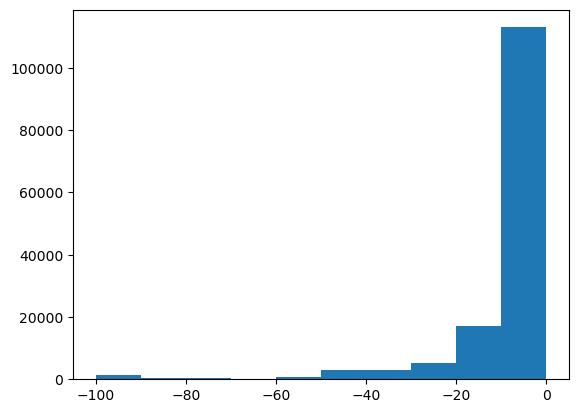

'\n    bin1: -10 <= x < 0\n    bin2: -50 <= x < -10\n    bin3: x < -50\n'

In [12]:
# 找出连续特征列,从中任取3列做等频分箱WOE、等距分箱WOE和自定义分箱WOE
continues_cols = [
    col for col in train.columns
    if train[col].dtype == 'float64'
]

# 自定义分箱WOE,查看特征分布
import matplotlib.pyplot as plt
plt.hist(train['id_01'])
plt.show()

"""
    bin1: -10 <= x < 0
    bin2: -50 <= x < -10
    bin3: x < -50
"""
train["id_01_customize_bins"] = train["id_01"].apply(lambda x:
                               'bin1_-10_0' if -10<= x <0 else
                               'bin2_-50_-10' if -50<= x <-10 else
                               'bin_3_less_than_-50' 
                                )
train,id_01_customize_bins_map = get_col_woe_score("id_01_customize_bins", train)

In [46]:
id_01_customize_bins_map

{'bin_3_less_than_-50': -0.1524215963976605,
 'bin1_-10_0': -0.19683304720295225,
 'bin2_-50_-10': 0.5635844950204418}

- 等距分箱

In [65]:
# 等距分箱
def get_equal_interval_bins(column:str, train:pd.DataFrame, bins=8):
    """等距分箱并返回结果

    Args:
        column (str): 特征列名
        train (pd.DataFrame): 训练数据
        bins (int, optional): 分箱数量一般采用5-10箱. Defaults to 8.

    return:
        分箱后的dataframe
    """
    minValue = train[column].min()
    maxValue = train[column].max()
    bin_interval = (maxValue - minValue) / bins

    def _apply_bin_func(value):
        bin_num = math.floor((value - minValue) / bin_interval)
        if bin_num < 8:
            bin_left = minValue + bin_num * bin_interval
            bin_right = minValue + (bin_num+1) * bin_interval

            bin_name = f"{column}_{bin_num}_{bin_left}_{bin_right}"
        else:
            bin_left = maxValue - bin_interval

            bin_name = f"{column}_{7}_{bin_left}_{maxValue}"

        return bin_name
        

    train[f"{column}_equal_interval_bins"] = train[f"{column}"].apply(lambda x: "NAN" if pd.isna(x) else _apply_bin_func(x))
                               
    return train

In [67]:
train = get_equal_interval_bins("id_02", train)
train["id_02_equal_interval_bins"].value_counts()

id_02_0_1.0_124950.25         70006
id_02_1_124950.25_249899.5    39958
id_02_2_249899.5_374848.75    15841
id_02_3_374848.75_499798.0     7559
id_02_4_499798.0_624747.25     3975
NAN                            3361
id_02_5_624747.25_749696.5     1886
id_02_6_749696.5_874645.75     1056
id_02_7_874645.75_999595.0      591
Name: id_02_equal_interval_bins, dtype: int64

In [70]:
train,id_02_equal_interval_bins_map = get_col_woe_score("id_02_equal_interval_bins", train)

In [76]:
sorted(id_02_equal_interval_bins_map.items(),key=lambda x:x[1])

[('NAN', -1.0633514027956514),
 ('id_02_0_1.0_124950.25', -0.15145017071321587),
 ('id_02_1_124950.25_249899.5', 0.0671116684769757),
 ('id_02_6_749696.5_874645.75', 0.13759577905134002),
 ('id_02_2_249899.5_374848.75', 0.19975269586234257),
 ('id_02_5_624747.25_749696.5', 0.3202828029856759),
 ('id_02_3_374848.75_499798.0', 0.34458205789659724),
 ('id_02_4_499798.0_624747.25', 0.37706343676468057),
 ('id_02_7_874645.75_999595.0', 0.5944386748745565)]

- 等频分箱

In [80]:
train["id_03"].value_counts(dropna=False)

 NaN     77909
 0.0     63903
 1.0       863
 3.0       668
 2.0       421
 5.0       109
 4.0       100
 6.0        64
-5.0        33
-6.0        31
-7.0        21
-4.0        21
-10.0       17
-8.0        14
-2.0        12
-1.0        12
-3.0         8
-9.0         6
-11.0        6
 7.0         4
 9.0         3
-12.0        3
-13.0        3
 10.0        1
 8.0         1
Name: id_03, dtype: int64

In [83]:
# 等频分箱
def get_equal_frequence_bins(column:str, train:pd.DataFrame, bins=8):
    """等频分箱并返回结果

    Args:
        column (str): 特征列名
        train (pd.DataFrame): 训练数据
        bins (int, optional): 分箱数量一般采用5-10箱. Defaults to 8.

    return:
        分箱后的dataframe
    """
    percentiles = np.linspace(0,1,bins+1)
    splits = np.percentile(train[column], percentiles * 100)

    def _apply_bin_func(value):
        if pd.isna(value):
            bin_name = "NAN"
        else:
            bin_name=''
            for i in range(bins):
                if splits[i] <= value < splits[i+1]:
                    bin_name = f"{column}_frequence_bin_{i}"
            if not bin_name:
                bin_name = f"{column}_frequence_bin_{bins-1}"

        return bin_name       

    train[f"{column}_equal_frequence_bins"] = train[f"{column}"].apply(lambda x: _apply_bin_func(x))
                               
    return train

In [87]:
train = get_equal_frequence_bins("id_03", train)

In [88]:
train["id_03_equal_frequence_bins"].value_counts()

NAN                      77909
id_03_frequence_bin_7    66324
Name: id_03_equal_frequence_bins, dtype: int64